#### K-Nearest Neighbors on breast cancer data ([Wisconsin original](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Original))
* classify clump type: benigh / malignant
* compare different data normalization
* compare the weight function of KNeighbors

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import sklearn.preprocessing as prep
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap
from sklearn.neighbors import KNeighborsClassifier

In [2]:
# load the data
flc = '/Users/pinqingkan/Desktop/DataScience/PythonDataScience/DAT210x-master/Module5/Datasets/'
fname = flc + 'breast-cancer-wisconsin.data'
columns = ['sample', 'thickness', 'size', 'shape', 'adhesion', 'epithelial',
           'nuclei', 'chromatin', 'nucleoli', 'mitoses', 'status']
X = pd.read_csv(fname, header = None, names = columns, index_col = 0)

In [3]:
X.head()

,thickness,size,shape,adhesion,epithelial,nuclei,chromatin,nucleoli,mitoses,status
sample,,,,,,,,,,
1000025,5,1,1,1,2,1,3,1,1,2
1002945,5,4,4,5,7,10,3,2,1,2
1015425,3,1,1,1,2,2,3,1,1,2
1016277,6,8,8,1,3,4,3,7,1,2
1017023,4,1,1,3,2,1,3,1,1,2


In [4]:
X.dtypes

thickness      int64
size           int64
shape          int64
adhesion       int64
epithelial     int64
nuclei        object
chromatin      int64
nucleoli       int64
mitoses        int64
status         int64
dtype: object

In [5]:
X.nuclei.unique()

array(['1', '10', '2', '4', '3', '9', '7', '?', '5', '8', '6'], dtype=object)

In [6]:
z = pd.to_numeric(X.nuclei, errors = 'coerce')
# fillup NaNs with mean values
z = z.fillna(z.mean(axis = 0))
X = X.drop(axis = 1, labels = 'nuclei')
X = pd.concat([X, z], axis = 1)

In [7]:
# separate into labels and data
Y = X.status
X = X.drop(labels = 'status', axis = 1)

In [8]:
Y.unique()

array([2, 4])

In [9]:
# change to 0 & 1 for plotting purpose
Y = Y/2-1

In [10]:
# split the datasets into training & testing data
# random_state = 7 to ensure repeatable results; skiped in real cases
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.5, random_state = 7)

In [11]:
# train the PCA using the training data & do PCA
# for visualization purpose
# first without normalization, select the K value
pca = PCA(n_components = 2, svd_solver = 'full')
pca.fit(X_train)
Z_train = pca.transform(X_train)
Z_test = pca.transform(X_test)

In [12]:
# apply KNeighbors on training data (normalized, PCA)
for K in np.arange(1, 16, 1):
    knc = KNeighborsClassifier(n_neighbors = K)
    knc.fit(Z_train, Y_train)
    # show the accuracy score
    print(K, knc.score(Z_test, Y_test))

1 0.945714285714
2 0.934285714286
3 0.96
4 0.951428571429
5 0.965714285714
6 0.965714285714
7 0.962857142857
8 0.962857142857
9 0.965714285714
10 0.96
11 0.965714285714
12 0.96
13 0.96
14 0.957142857143
15 0.96


In [13]:
# train the isomap using the normalized training data & do isomap
# for visualization purpose
# first without normalization, select the K value
iso = Isomap(n_neighbors = 4, n_components = 2, eigen_solver = 'auto', max_iter = None,
             neighbors_algorithm = 'auto', path_method = 'auto', tol = 0)
iso.fit(X_train)
W_train = iso.transform(X_train)
W_test = iso.transform(X_test)

In [14]:
# apply KNeighbors on training data (normalized, isomap)
for K in np.arange(1, 16, 1):
    knc = KNeighborsClassifier(n_neighbors = K)
    knc.fit(W_train, Y_train)
    # show the accuracy score
    print(K, knc.score(W_test, Y_test))

1 0.948571428571
2 0.922857142857
3 0.951428571429
4 0.948571428571
5 0.965714285714
6 0.951428571429
7 0.954285714286
8 0.954285714286
9 0.957142857143
10 0.951428571429
11 0.951428571429
12 0.948571428571
13 0.948571428571
14 0.942857142857
15 0.951428571429


In [15]:
# plot a classified contour
def contour_KNC(W_train, Y_train, knc):
    # the range of the contour
    xmin, xmax = W_train[:,0].min(), W_train[:,0].max()
    ymin, ymax = W_train[:,1].min(), W_train[:,1].max()
    x_range = xmax - xmin
    y_range = ymax - ymin
    padding = 0.3
    xmin -= x_range * padding
    ymin -= y_range * padding
    xmax += x_range * padding
    ymax += y_range * padding

    # the grids of the contour
    resolution = .1
    xx, yy = np.meshgrid(np.arange(xmin, xmax, resolution),
                         np.arange(ymin, ymax, resolution))

    # show the classified contour
    zz = knc.predict(np.c_[xx.ravel(), yy.ravel()])
    zz = zz.reshape(xx.shape)
    plt.contourf(xx, yy, zz)
    colors = ['blue','red']
    for label in range(len(np.unique(Y_train))):
        indices = np.where(Y_train == label)
        plt.scatter(W_train[indices,0], W_train[indices,1], c = colors[label])

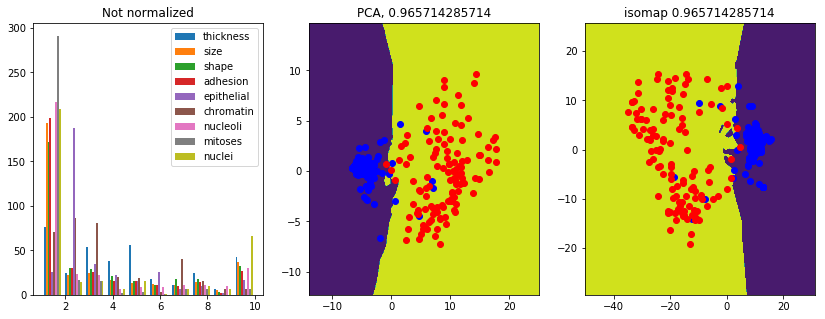

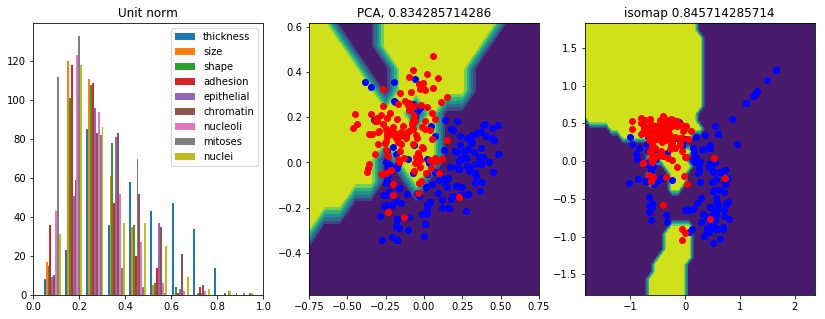

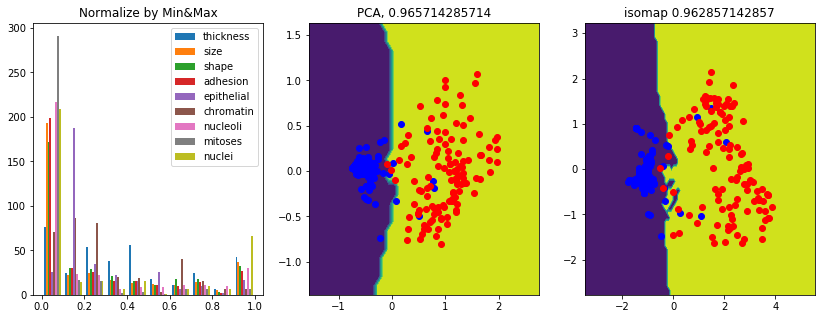

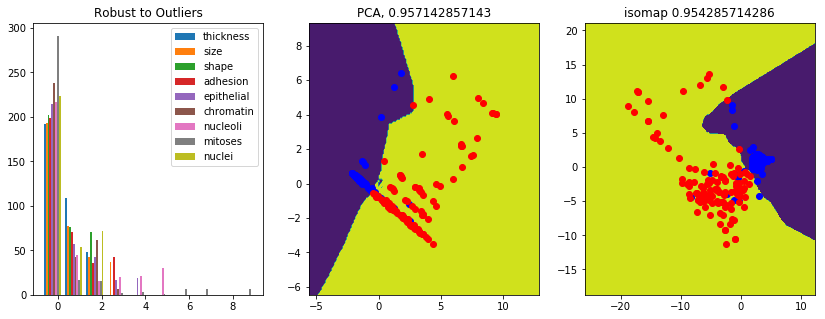

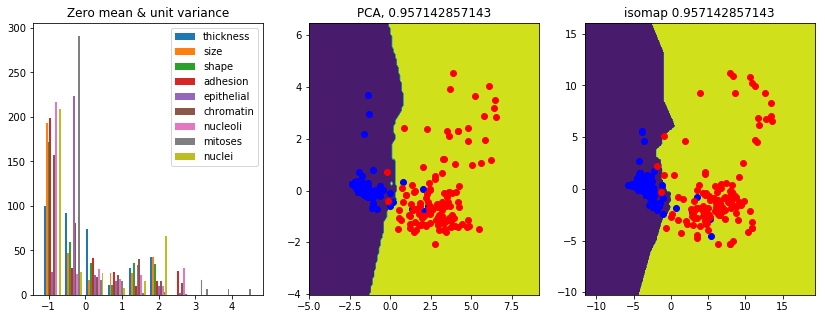

In [16]:
# train the normalizer using the training data & normalize
# -- compare different normalization method
norms = np.arange(5)
for inorm in norms:
    if inorm == 0:
        X_train0 = X_train.as_matrix()
        X_test0 = X_test.as_matrix()
        fttl = 'Not normalized'
    else:
        if inorm == 1:
            norm = prep.Normalizer()
            fttl = 'Unit norm'
        elif inorm == 2:
            norm = prep.MinMaxScaler()
            fttl = 'Normalize by Min&Max'
        elif inorm == 3:
            norm = prep.RobustScaler()
            fttl = 'Robust to Outliers'
        elif inorm == 4:
            norm = prep.StandardScaler()
            fttl = 'Zero mean & unit variance'
        norm.fit(X_train)
        X_train0 = norm.transform(X_train)
        X_test0 = norm.transform(X_test)
    
    # view the normalized data
    plt.figure(inorm, figsize = (14,5))
    plt.subplot(131)
    plt.hist(X_train0, label = list(X.columns.values))
    plt.legend()
    plt.title(fttl)
    
    # do PCA on normalized data
    pca = PCA(n_components = 2, svd_solver = 'full')
    pca.fit(X_train0)
    Z_train = pca.transform(X_train0)
    Z_test = pca.transform(X_test0)
    
    # do KNeighbors on normalized data
    K = 5
    knc = KNeighborsClassifier(n_neighbors = K)
    knc.fit(Z_train, Y_train)
    
    plt.subplot(132)
    contour_KNC(Z_train, Y_train, knc)
    plt.title('PCA, ' + str(knc.score(Z_test, Y_test)))

    # do isomap on normalized data
    iso = Isomap(n_neighbors = 4, n_components = 2, eigen_solver = 'auto', max_iter = None,
             neighbors_algorithm = 'auto', path_method = 'auto', tol = 0)
    iso.fit(X_train0)
    W_train = iso.transform(X_train0)
    W_test = iso.transform(X_test0)

    # do KNeighbors on normalized data
    K = 5
    knc = KNeighborsClassifier(n_neighbors = K)
    knc.fit(W_train, Y_train)

    plt.subplot(133)
    contour_KNC(W_train, Y_train, knc)
    plt.title('isomap ' + str(knc.score(W_test, Y_test)))

    plt.show()

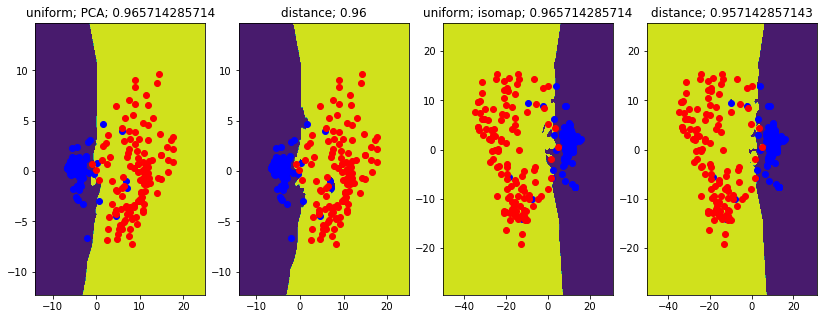

In [17]:
# compare the weight function of KNC

pca = PCA(n_components = 2, svd_solver = 'full')
pca.fit(X_train)
Z_train = pca.transform(X_train)
Z_test = pca.transform(X_test)

plt.figure(figsize = (14,5))

K = 5

knc = KNeighborsClassifier(n_neighbors = K)
knc.fit(Z_train, Y_train)
plt.subplot(141)
contour_KNC(Z_train, Y_train, knc)
plt.title('uniform; PCA; ' + str(knc.score(Z_test, Y_test)))

knc = KNeighborsClassifier(n_neighbors = K, weights = 'distance')
knc.fit(Z_train, Y_train)
plt.subplot(142)
contour_KNC(Z_train, Y_train, knc)
plt.title('distance; ' + str(knc.score(Z_test, Y_test)))

iso = Isomap(n_neighbors = 4, n_components = 2, eigen_solver = 'auto', max_iter = None,
             neighbors_algorithm = 'auto', path_method = 'auto', tol = 0)
iso.fit(X_train)
W_train = iso.transform(X_train)
W_test = iso.transform(X_test)

knc = KNeighborsClassifier(n_neighbors = K)
knc.fit(W_train, Y_train)
plt.subplot(143)
contour_KNC(W_train, Y_train, knc)
plt.title('uniform; isomap; ' + str(knc.score(W_test, Y_test)))

knc = KNeighborsClassifier(n_neighbors = K, weights = 'distance')
knc.fit(W_train, Y_train)
plt.subplot(144)
contour_KNC(W_train, Y_train, knc)
plt.title('distance; ' + str(knc.score(W_test, Y_test)))

plt.show()